# Contact Tracer

One of the main problems with this approach is what is the information that we are going to use. I was looking in internet and I did not find any information about tracing people.
Once we have the data, we have to select the important informatio we are going to work with.

1) Information from the people, just about interaction between them?

2) How this interaction change the probability of been positive

## Qiskit Model
As I mentioned in our last meeting IBMQ has a quantum simulator with just 32 qubits. Therefore, we are restricted to work with this amount of people 

# Load the account of IBMQ
Remember that you need an account in IBMQ. Here is the link for creating the account https://quantum-computing.ibm.com 
There are real devices, but, those have a lot of noise and do not have enough number of qubits.

In [3]:
import qiskit as qk
from qiskit import IBMQ

provider = IBMQ.load_account()
backends = provider.backends()
names = []
for backend in backends:
    names.append(backend.name())
    
print(names)

ibmqfactory.load_account:WARNING:2020-06-26 22:01:48,865: Credentials are already in use. The existing account in the session will be replaced.


['ibmq_qasm_simulator', 'ibmqx2', 'ibmq_16_melbourne', 'ibmq_vigo', 'ibmq_ourense', 'ibmq_london', 'ibmq_burlington', 'ibmq_essex', 'ibmq_armonk', 'ibmq_rome']


# Quantum Simulator
The quantum simulator is our best candidate for simulating the propagation of the virus. 


In [6]:
backend = provider.get_backend('ibmq_qasm_simulator')
configuration = backend.configuration().to_dict()
n_qubits = backend.configuration().n_qubits
print(n_qubits)

32


## Circuit Representing the interactions 
This is how the circuit is going to be. We need the rules that will control the interaction between people. 

In [245]:
circuit = qk.QuantumCircuit(32)
circuit.h([i for i in range(n_qubits) if i % 2 == 0])
circuit.cx([0,1],[2,3])
#circuit.draw('mpl')

## Example of contact
Imagine two people represented by the following qubits:

$$ P_1  = \alpha\left|0\right> + \beta\left|1\right>$$
$$ P_2  = \gamma\left|0\right> + \delta\left|1\right>$$

where $|\alpha|^2$ represent the probability of $P_1$ for not being infected and $|\beta|^2$ the probability of $P_1$ for being infected (The same for person two $P_2$). Therefore, the state is:

$$ P_1 \otimes P_2  = \alpha\gamma\left|00\right> + \alpha\delta\left|01\right> + \beta\gamma\left|10\right> +\beta\delta \left|11\right>$$

Applying a CNOT gate ($U_{CNOT}\left[P_1\otimes P_2\right] = P_1 \otimes (P_1 \oplus P_2)$):

$$ P_1 \otimes P_2  = \alpha\gamma\left|00\right> + \alpha\delta\left|01\right> + \beta\gamma\left|11\right> +\beta\delta \left|10\right>$$

In this case we are just interested in the last two cases which are the cases that tell us what happens with the second person if the first person is infected. We can eliminate the first two states starting the first person in the state $P_1 = \left|1\right>$. In this case $\alpha = 0$ and $\beta = 1$.

$$ P_1 \otimes P_2  = \gamma\left|10\right> + \delta \left|11\right>$$

Here, we have to apply a gate to the second qubit based on the interaction that this qubit had with the first qubit (In terms of people). Then, $\gamma$ and $\delta$ represent the interaction, we can use rotations around x to get this.Here, $\theta$ corresponds the degree of interaction of the second person with the first, $\theta = 0$ means the interaction does not generate infection and $\theta = \pi$ means the interaction generates infection.

$$R_x(\theta) = \begin{bmatrix} cos(\theta/2) & -i sin(\theta/2) \\ -i sin(\theta/2) & cos(\theta/2)\end{bmatrix}$$

### In fact, we do not need to use a cnot gate and a rotation gate. Qiskit has a controlled x-rotation.

# Example
Let's analys a simple case. Here, we have interaction between five people, in the way shown in the graph below. We have to extend the interaction from one way to both ways between nodes in our Quantum Computing model.

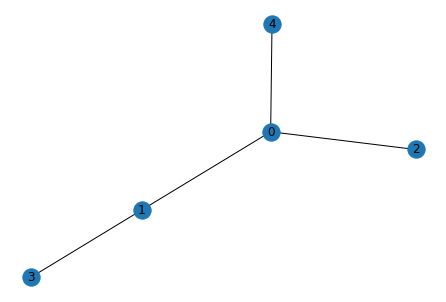

In [4]:
import networkx as nx
G = nx.Graph()
G.add_nodes_from([0,1,2,3,4])
G.add_edges_from([(0,1),(0,2),(1,3),(0,4)])
nx.draw(G, with_labels = True)

We can do it adding a second controlled x-rotation in the inverse way. Now, we need the angles of rotation based on the interaction between people. I propose 

$$\theta(t) = \pi(1 - e^{t/T})$$

where $t$ is the interaction time and $T$ is a constant that determines how fast the contact increment the probability of being infected (It should based on some study). Now, the main problem is what we are going to measure.

My suggestion is exemplify by the next case:

Imagine that in our case $P_2$ and $P_3$ are going to take a test and it is positive. Then, we have the algorithm to track which of the people that were in contact with $P_2$ and $P_3$ have more probability to being infected. Even more, we can track the origin of the infection! Because, we have the order in which $P_2$ had contact with $P_0$ and $P_3$ with $P_1$. We just need to put the interaction gates in the order of interaction between people. 

Suppose $P_1$ is the origin of the infection but he does not know yet. Traking the history, we have the order of events:

1) $P_4$ interacts with $P_0$

2) $P_0$ interacts with $P_1$

3) $P_0$ interacts with $P_2$

4) $P_1$ interacts with $P_3$

The qiskit code for this is:


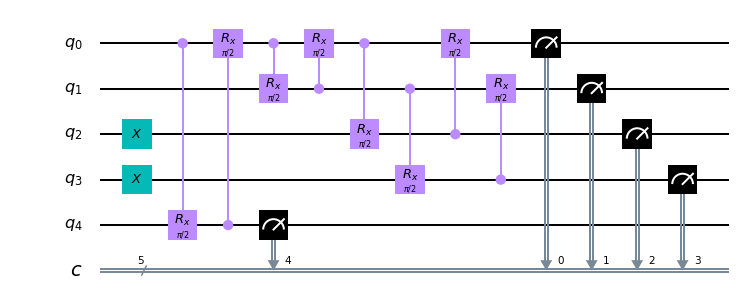

In [201]:
# Toy example
import numpy as np
theta01 = np.pi/2;theta02 = np.pi/2;theta04 = np.pi/2;theta13 = np.pi/2
circuit = qk.QuantumCircuit(5,5)
theta = np.pi/4 # rotation angle about x-axis
circuit.x(2) # P2 gives positive in the test
circuit.x(3) # P3 gives positive in the test
# Chronology of events:
circuit.crx(theta04,[0,4],[4,0]) # Interaction P4 with P0
circuit.crx(theta01,[0,1],[1,0]) # Interaction P4 with P0
circuit.crx(theta02,[0,2],[2,0]) # Interaction P4 with P0
circuit.crx(theta13,[1,3],[3,1]) # Interaction P4 with P0
circuit.measure([0,1,2,3,4],[0,1,2,3,4])
circuit.draw('mpl')

In [232]:
from qiskit import Aer
backend = Aer.get_backend('qasm_simulator')
shots = 1000
job = qk.execute(circuit,backend,shots = shots)

def probability_infected(results,qubit,shots):
    #Remember the qubits are counted from right to left, that means q0 position is -1
    one = 0
    for key,count in results.items():
        if key[-(qubit + 1)] == '1':
            one += count
    return 100*(one / shots)

Probability P0 of being infected :  46.6
Probability P1 of being infected :  48.7
Probability P2 of being infected :  100.0
Probability P3 of being infected :  100.0
Probability P4 of being infected :  0.0


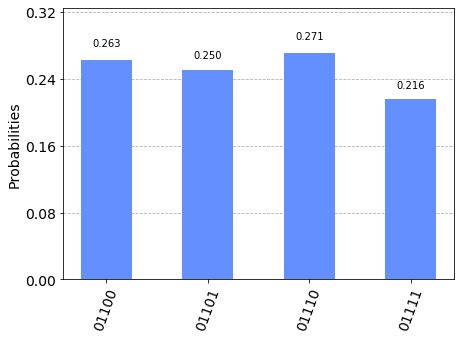

In [244]:
from qiskit.visualization import plot_histogram
results = job.result().get_counts()
people = 5
for person in range(people):
    print("Probability P{} of being infected : ".format(person),round(probability_infected(results,person,shots),2))
plot_histogram(results)

Here, we can see that the probability of $P_4$ is zero, because, He was in contact with $P_0$, before $P_0$ got infected. The difference in probability between $P_0$ and $P_1$ shows that $P_1$ is more likely being the origin of the infection.